In [13]:
from sort import *
import cvzone
from sort import *
import math
import numpy as np
import cv2

import cv2
import matplotlib.pyplot as plt
from incremental_explainer.metrics.metrics import compute_insertion
from incremental_explainer.transformations.image_scaling import scale_image
from incremental_explainer.transformations.image_moving import move_image
from incremental_explainer.explanations import compute_explanation
from incremental_explainer.utils.saliency_maps import compute_saliency_maps
from ultralytics import YOLO

def calculate_intersection_over_union(square1, square2):
    x1 = max(square1[0], square2[0])
    y1 = max(square1[1], square2[1])
    x2 = min(square1[2], square2[2])
    y2 = min(square1[3], square2[3])

    area_square1 = (square1[2] - square1[0]) * (square1[3] - square1[1])
    area_square2 = (square2[2] - square2[0]) * (square2[3] - square2[1])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    union_area = area_square1 + area_square2 - intersection_area

    iou = intersection_area / union_area if union_area > 0 else 0

    return iou


def get_key_by_value(dictionary, value):
    max_iou = 0
    best_key = None
    for key, square in dictionary.items():
        iou = calculate_intersection_over_union(square, value)
        if iou > max_iou:
            max_iou = iou
            best_key = key
    return best_key


def plot_boxes(results, img, detections, model):
    classes = []
    confidence = {}
    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            w, h = x2 - x1, y2 - y1

            cls = int(box.cls[0])
            currentClass = model.model.names[cls]

            conf = math.ceil(box.conf[0] * 100) / 100
            currentArray = np.array([x1, y1, x2, y2, conf])
            detections = np.vstack((detections, currentArray))
            classes.append(cls)
            confidence[(x1, y1, x2, y2)] = conf
            # cvzone.putTextRect(img, f'{str(currentClass).upper()}: {conf}', (x1+10,y1-10), scale=1.5, thickness=2, colorR=(0,0,255),font=cv2.FONT_HERSHEY_PLAIN)
            # img = cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0), thickness=3)
    return [detections, classes], img, confidence


def track_detect(r, img, tracker, model, first_id, previous_dim, results, exp, first_exp, box_index, image_location, class_name, confidence_dict):
    detections, _ = r
    resultTracker = tracker.update(detections)
    center_changes = {}
    counter = 0
    height = img.shape[0]
    width = img.shape[1]
    light_blue = (31, 112, 255)
    for i, res in enumerate(resultTracker):
        x1, y1, x2,y2, id = res
        x1, y1, x2, y2, id = int(x1), int(y1), int(x2), int(y2), int(id)
        matching_index_x = 0
        if (first_id == id):
            x1_old, y1_old, x2_old, y2_old = previous_dim
            best_iou = 0
            for i, detection in enumerate(detections):
                iou = calculate_intersection_over_union((detection[0], detection[1], detection[2], detection[3]), (x1, y1, x2, y2))
                if iou > best_iou:
                    matching_box = detection
                    matching_index_x = i
            confidence = confidence_dict[(matching_box[0], matching_box[1], matching_box[2], matching_box[3])]
            print(f'x_old: {x1_old}, y_old: {y1_old}, x2_old: {x2_old}, y2_old: {y2_old}')
            old_x = abs(x1_old - x2_old)
            old_y = abs(y1_old - y2_old)
            new_x = abs(x1 - x2)
            new_y = abs(y1 - y2)

            scale_x = new_x / old_x
            scale_y = new_y / old_y
            exp_scaled = scale_image(first_exp, scale_x, scale_y)

            old_bb_center = np.array([(x1_old + x2_old) / 2, (y1_old + y2_old) / 2])
            new_bb_center = np.array([(x1 + x2) / 2, (y1 + y2) / 2])

            old_image_center = np.array([width / 2, height / 2])
            scaled_image_center = np.array([exp_scaled.shape[1] / 2, exp_scaled.shape[0] / 2])
            scaled_bb_center = np.array([(old_bb_center[0] - old_image_center[0]) * scale_x + scaled_image_center[0], (old_bb_center[1] - old_image_center[1]) * scale_y + scaled_image_center[1]])

            center_changes = new_bb_center - scaled_bb_center

            exp = move_image(
                np.transpose(exp_scaled, (0, 1)),
                int(center_changes[0]),
                int(center_changes[1]),
                (height, width),
            )
            cvzone.putTextRect(
                img,
                text=f"{class_name}:{confidence}, id: {first_id}",
                pos=(x1 + 10, y1 - 10),
                scale=1.5,
                thickness=2,
                colorR=light_blue,
                font=cv2.FONT_HERSHEY_PLAIN,
            )
            img = cv2.rectangle(img, (x1, y1), (x2, y2), light_blue, thickness=3)
            return (exp, first_exp, previous_dim, first_id, img, (x1, y1, x2, y2), matching_index_x)

        if first_id == -1 and (
            detections[box_index][0] == x1
            and detections[box_index][1] == y1
            and detections[box_index][2] == x2
            and detections[box_index][3] == y2
        ):
            print(f"x: {x1}, y: {y1}, x2: {x2}, y2: {y2}")
            first_id = id
            print(f'Class: {class_name}, Confidence: {confidence_dict[(x1,y1,x2,y2)]}')
            res = compute_saliency_maps(results, image_location, model)
            # print(image_location)
            # print(results)
            print("Finished first saliency map")
            # print(confidence_dict)
            cvzone.putTextRect(
                img,
                text=f"{class_name}: {confidence_dict[(x1,y1,x2,y2)]}, id: {first_id}",
                pos=(x1 + 10, y1 - 10),
                scale=1.5,
                thickness=2,
                colorR=light_blue,
                font=cv2.FONT_HERSHEY_PLAIN,
            )
            img = cv2.rectangle(img, (x1, y1), (x2, y2), light_blue, thickness=3)
            # print(len(res))

            return (
                res[box_index]["detection"][0].numpy(),
                res[box_index]["detection"][0].numpy(),
                (x1, y1, x2, y2),
                first_id,
                img,
                (x1, y1, x2, y2),
                box_index
            )
        counter += 1
    return ([], first_exp, previous_dim, first_id, img, previous_dim, box_index)


def track_saliency_maps(frame_number, car_number, box_index_first_frame):
    model = YOLO("yolov8n.pt")
    tracker = Sort(max_age=20, min_hits=3, iou_threshold=0.3)
    first_id = -1
    previous_dim = (0, 0, 0, 0)
    exp = [0]
    first_exp = []
    frames = []
    auc_results = []
    auc_results_2 = []
    first_level = -1
    class_id = -1
    class_name = ""
    light_blue = (31, 112, 255)
    tolerance_counter = 0
    max_frame_tolerance = 30 * 5
    while True:
        image_location = f"datasets/car/car-{car_number}/img/{str(frame_number).zfill(8)}.jpg"
        if not os.path.exists(image_location):
            break
        img = cv2.imread(image_location)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = model(img, verbose=False)
        if (first_id == -1):
            plt.imshow(results[0].plot())
            plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
            plt.axis('off')
            plt.tight_layout()
            plt.show()
        detections, frame, confidence_dict = plot_boxes(results, img, np.empty((0,5)), model)
        _, classes = detections
        if len(results[0].boxes.cls) <= box_index_first_frame:
            box_index_first_frame = 0
        #print(classes)
        if class_name == "":
            if len(results[0].boxes.cls) == 0:
                break
            class_name = model.names[classes[box_index_first_frame]]
        det, classes = detections
        class_dict = {}
        for det, cl in zip(det, classes):
            class_dict[tuple(det[0:4].astype(np.int32))] = cl
        original = img.copy()
        #print(detections)
        new_exp, first_exp, previous_dim, first_id, img_boxes, current_dim, matching_index = track_detect(
                detections,
                img,
                tracker,
                model,
                first_id,
                previous_dim,
                results,
                exp,
                first_exp,
                box_index_first_frame,
                image_location,
                class_name,
                confidence_dict
            )
        
        if abs(previous_dim[0] - previous_dim[2]) == 0 or abs(previous_dim[1] - previous_dim[3]) == 0:
            print("Skipped")
            break

        if len(new_exp) == 0:
            tolerance_counter += 1
            if tolerance_counter > max_frame_tolerance:
                for i in range(max_frame_tolerance):
                    frames.pop()
                break
            frames.append(cv2.hconcat([original, np.zeros_like(original)]))
            frame_number += 1
            continue
        else:
            tolerance_counter = 0

        exp = new_exp
        viridis_frame = plt.cm.viridis(new_exp)
        viridis_frame_rgb = viridis_frame[:, :, :3]  # Extract RGB channels

        # Blending using OpenCV's addWeighted
        alpha = 0.5  # You can adjust the alpha value as needed
        dst = cv2.addWeighted(
                img_boxes, alpha, (viridis_frame_rgb * 255).astype(np.uint8), 1 - alpha, 0
            )
        if (class_id == -1):
            class_id = results[0].boxes.cls.numpy().astype("uint32")[box_index_first_frame]

        min_expl, first_level = compute_explanation(original, class_id, exp, first_level, model)

        min_expl = cv2.rectangle(
                min_expl,
                (current_dim[0], current_dim[1]),
                (current_dim[2], current_dim[3]),
                light_blue,
                thickness=3,
            )
        res = compute_saliency_maps(results, image_location, model)
        print(matching_index, box_index_first_frame, len(results[0].boxes.cls), len(res))
        exp_2 = res[matching_index]["detection"][0].numpy()
    
        viridis_frame = plt.cm.viridis(exp_2)
        viridis_frame_rgb = viridis_frame[:, :, :3]  # Extract RGB channels
        alpha = 0.5  # You can adjust the alpha value as needed
        dst2 = cv2.addWeighted(
                img_boxes, alpha, (viridis_frame_rgb * 255).astype(np.uint8), 1 - alpha, 0
            )
        min_expl_2, _ = compute_explanation(original, class_id, exp_2, -1, model)
        print(dst2.shape, dst.shape)
        final_frame = cv2.hconcat([dst, min_expl, dst2, min_expl_2])

        frames.append(final_frame)
        frame_number += 1
        
        results = compute_insertion(model = model, saliency_map=exp, image=original, class_index=class_id)
        results_2 = compute_insertion(model = model, saliency_map=exp_2, image=original, class_index=class_id)
        auc_results.append(results)
        auc_results_2.append(results_2)
        print(f"AUC: {results}")
        print(f"AUC_2: {results_2}")
        
    return frames, [1], [1]

In [14]:
from incremental_explainer.utils.video import create_video, save_video

def track_saliency_maps_with_video(frame_number, car_set_object, box_index):

    print(f"Frame number: {frame_number}, Car number: {car_set_object}, Explanation index: {box_index}")

    frames, auc_results, aux_results_2 = track_saliency_maps(frame_number=frame_number, car_number=car_set_object, box_index_first_frame=box_index)
    
    plt.boxplot(auc_results)
    mean_value = sum(auc_results) / len(auc_results)
    plt.title(f"Incremental results - Average: {mean_value}")
    plt.show()
    mean_value = sum(aux_results_2) / len(aux_results_2)
    plt.boxplot(aux_results_2)
    plt.title(f"Plain DRise results - Average: {mean_value}")
    plt.show()
    print(f"Number of frames: {len(frames)}")
    if len(frames) > 0:
        display(create_video(frames))
        save_video(frames, frame_number, car_set_object, box_index)

Frame number: 1468, Car number: 10, Explanation index: 1


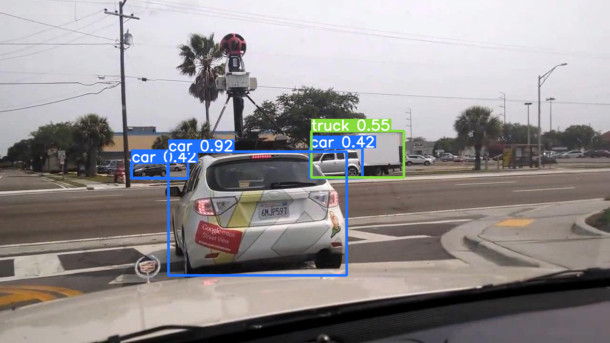

x: 653, y: 276, x2: 847, y2: 373
Class: truck, Confidence: 0.56


100%|██████████| 99/99 [00:00<00:00, 191.81it/s]


Finished first saliency map


100%|██████████| 99/99 [00:00<00:00, 203.87it/s]


1 1 5 5
(720, 1280, 3) (720, 1280, 3)
AUC: 0.4990239484962917
AUC_2: 0.5153724993643441
x_old: 653, y_old: 276, x2_old: 847, y2_old: 373


100%|██████████| 99/99 [00:00<00:00, 431.29it/s]


1 1 2 2
(720, 1280, 3) (720, 1280, 3)
AUC: 0.3951965777992316
AUC_2: 0.40630879368962874
x_old: 653, y_old: 276, x2_old: 847, y2_old: 373


100%|██████████| 99/99 [00:00<00:00, 587.40it/s]


0 0 1 1
(720, 1280, 3) (720, 1280, 3)
AUC: 0.5314091114374524
AUC_2: 0.5266932537405389
x_old: 653, y_old: 276, x2_old: 847, y2_old: 373


100%|██████████| 99/99 [00:00<00:00, 419.48it/s]


1 0 2 2
(720, 1280, 3) (720, 1280, 3)
AUC: 0.6105718420550693
AUC_2: 0.6234838279364825
x_old: 653, y_old: 276, x2_old: 847, y2_old: 373


100%|██████████| 99/99 [00:00<00:00, 349.82it/s]


1 0 2 2
(720, 1280, 3) (720, 1280, 3)
AUC: 0.4069440784228047
AUC_2: 0.39704237377573415


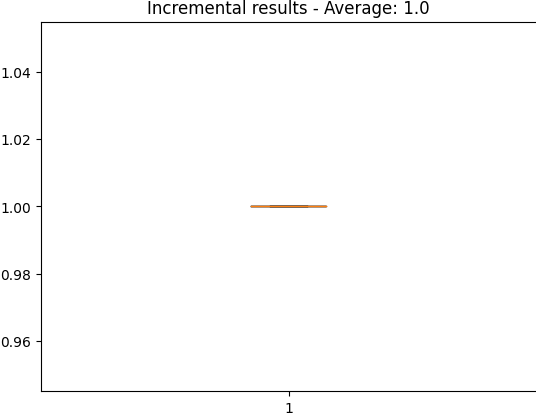

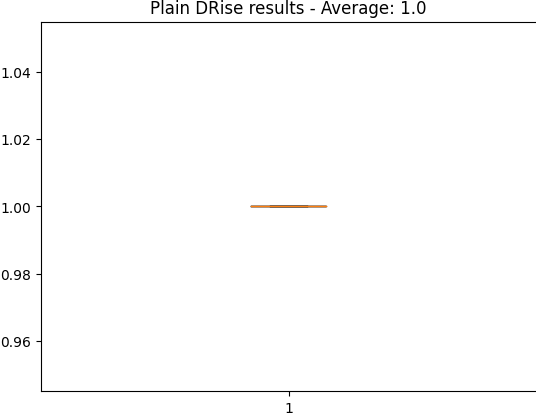

Number of frames: 5


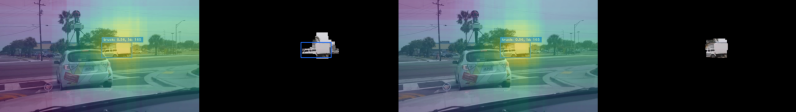

In [15]:
track_saliency_maps_with_video(1468, 10, 1)

# for j in range(1, 100):
#     frame_number = random.randint(1, 1500)
#     car_number = random.randint(11, 20)
#     while car_number == 7 or car_number == 5 or car_number == 4:
#         car_number = random.randint(1, 10)
#     box_index = random.randint(0, 3)
#     track_saliency_maps_with_video(frame_number, car_number, box_index)